In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as lng
import time
import pandas as pd
from scipy.sparse.linalg import spsolve
from scipy import sparse
import scipy.linalg as lng_scp
plt.rcParams["figure.figsize"]=(16,9)

In [26]:
#Possibilities are EE, IE-SPLIT, CN-SPLIT, IE-PSOR, IE-PSOR-RELAXED, IE-NEWTON, IE-UL, HIGHER_ORDER
Scheme='IE-NEWTON'

In [27]:
#the things below are same for all schemes so I just code them here
K=100
S_min=50
S_max=250
T=1
sigma=0.3
r=0.1

In [4]:
s_val=90
def phi(S,I):
    return np.maximum(K-S,0.).reshape(I,1)
def phi2(S,I):
    out=np.zeros_like(S)
    for i in range(I):
        if (S[i]<=K and S[i]>=K/2):
            out[i]=K
    return out
def phi3(S,I):
    out=np.zeros_like(S)
    for i in range(I):
        if (S[i]<=K and S[i]>=K/2):
            out[i]=K
    return out
def vL(t,S_min):
    return K-S_min
def vR(t):
    return 0
def interpolated_value(s_bar,h,U,S,S_min):
    i=int((s_bar-S_min)/h)-1
    return float((S[i+1]-s_bar)*U[i]/h+(s_bar-S[i])*U[i+1]/h)

def make_output_table (table,s_val,K,r,sigma):
    table["error"]=np.abs(table['U(%.2f)' %s_val].diff())
    for i in range(1, len(table)):
        table.loc[i,"time error order"]=np.log(table.loc[i-1,"error"]/table.loc[i,"error"])/np.log((table.loc[i,"N"])/(table.loc[i-1,"N"]))
        table.loc[i,"space error order"]=np.log(table.loc[i-1,"error"]/table.loc[i,"error"])/np.log((table.loc[i,"I"]+1)/(table.loc[i-1,"I"]+1))
    return table

In [5]:
def EE(N,U,A,delta_t,alpha,beta,S_min,I):
    q=np.zeros_like(U)
    g=U
    for n in range(N):
        t=delta_t*n
        q[0]=(-alpha[0]+beta[0])*vL(t,S_min)
        q[-1]=(-alpha[-1]-beta[-1])*vR(t)
        U=np.maximum((np.eye(I)-delta_t*A) @(U-delta_t*q),g).reshape(I,1)
        g=U
    return U.reshape(I,1)

def IE_Split(N,U,A,delta_t,alpha,beta,S_min,I):
    q=np.zeros_like(U)
    g=U
    for n in range(N):
        t=delta_t*(n+1)
        q[0]=(-alpha[0]+beta[0])*vL(t,S_min)
        q[-1]=(-alpha[-1]-beta[-1])*vR(t)
        U=np.maximum((lng.solve(np.eye(I)+delta_t*A,U-delta_t*q)).reshape(I,1),g)
        g=U
    return U.reshape(I,1)

def CN_Split(N,U,A,delta_t,alpha,beta,S_min,I):
    q=np.zeros_like(U)
    g=U
    for n in range(N):
        t=delta_t*(n+1)
        q[0]=(-alpha[0]+beta[0])*vL(t,S_min)
        q[-1]=(-alpha[-1]-beta[-1])*vR(t)
        U=lng.solve(np.eye(I)+delta_t*A/2,(np.eye(I)-delta_t*A/2) @(U)-delta_t*q)
        U=np.maximum(U,g)
        g=U
    return U.reshape(I,1)
    
def newton(B,b,g,k_max,x0):
    k=0
    x=x0
    while (k<k_max):
        F_derivative=np.zeros_like(B)
        for i in range(I):
            vec=B@(x)
            #if ((B@(x)[i]-b[i])<=x[i]-g[i]):
            if ((vec[i]-b[i])<=(x[i]-g[i])):
                for j in range(I):
                    F_derivative[i,j]=B[i,j]
            if ((vec[i]-b[i])>(x[i]-g[i])):
                F_derivative[i,i]=1
        F=np.minimum(B@(x)-b,x-g)
        x=x-lng.solve(F_derivative,F)
        k=k+1
    return x

def Psor(L,b,g,I,k_max,x0,U_matrix):
    k=0
    x=x0
    xold=x0
    while (k<k_max):
        c=b-U_matrix@(xold)
        xold=x
        for i in range(I):
            sum_mult=0
            for j in range(I):
                if (j!=i):
                    sum_mult=sum_mult+L[i,j]*x[j]
            x[i]=(c[i]-sum_mult)/L[i,i]
            x[i]=np.maximum(x[i],g[i])
        k=k+1
    return x

def uldecomp(B):
    [P,L,U]=lng_scp.lu(B)
    if (P@(L@(U))!=B).any():
        print ('decomposition failed!')
    return [L,U]

def downwind(L,c,g,I):
    x=np.zeros_like(c)
    for i in range(I):
        sum_L_times=0
        for j in range(i):
            sum_L_times=sum_L_times+L[i,j]*x[j]
        x[i]=(c[i]-sum_L_times)/L[i,i]
        x[i]=np.maximum(x[i],g[i])
    return x
    

def IE_Psor(N,U,A,delta_t,alpha,beta,S_min,I,x0,k_max):
    q=np.zeros_like(U)
    g=U
    B=np.eye(I)+delta_t*A
    U_matrix=np.triu(B,k=1)
    L=np.tril(B,k=0)
    for n in range(N):
        t=delta_t*(n+1)
        q[0]=(-alpha[0]+beta[0])*vL(t,S_min)
        q[-1]=(-alpha[-1]-beta[-1])*vR(t)
        b=U-delta_t*q
        U=Psor(L,b,g,I,k_max,x0,U_matrix)
        x0=U
        error_min=np.minimum(B@(U)-(b),U-g)
        print("the minimum in scheme has inf error:",lng.norm(error_min,np.inf),"for iteration:",n)
    return U.reshape(I,1)

def IE_Psor_relaxed(N,U,A,delta_t,alpha,beta,S_min,I,x0,k_max,w):
    q=np.zeros_like(U)
    g=U
    B=np.eye(I)+delta_t*A
    U_matrix=np.triu(B,k=1)
    L=np.tril(B,k=0)
    D=np.diag(np.diag(A))
    L=(1/w-1)*D+L
    U_matrix=B-L
    for n in range(N):
        t=delta_t*(n+1)
        q[0]=(-alpha[0]+beta[0])*vL(t,S_min)
        q[-1]=(-alpha[-1]-beta[-1])*vR(t)
        b=U-delta_t*q
        U=Psor(L,b,g,I,k_max,x0,U_matrix)
        x0=U
        error_min=np.minimum(B@(U)-(b),U-g)
        print("the minimum in scheme has inf error:",lng.norm(error_min,np.inf),"for iteration:",n)
    return U.reshape(I,1)

def IE_Newton(N,U,A,delta_t,alpha,beta,S_min,I,x0,k_max):
    q=np.zeros_like(U)
    g=U
    B=np.eye(I)+delta_t*A
    for n in range(N):
        t=delta_t*(n+1)
        q[0]=(-alpha[0]+beta[0])*vL(t,S_min)
        q[-1]=(-alpha[-1]-beta[-1])*vR(t)
        #print (U,delta_t,q)
        b=U-delta_t*q
        U=newton(B,b,g,k_max,x0)
        x0=U
    return U.reshape(I,1)

def IE_UL(N,U,A,delta_t,alpha,beta,S_min,I):
    q=np.zeros_like(U)
    g=U
    B=np.eye(I)+delta_t*A
    [L,U_matrix]=uldecomp(B)
    for n in range(N):
        t=delta_t*(n+1)
        q[0]=(-alpha[0]+beta[0])*vL(t,S_min)
        q[-1]=(-alpha[-1]-beta[-1])*vR(t)
        b=U-delta_t*q
        c=lng.solve(U_matrix,b)
        U=downwind(L,c,g,I)
        error_min=np.minimum(B@(U)-b,U-g)
        #for the error while computing the x such that F(x)=0 we will print it if the error is not very small, eg >0.05
        if lng.norm(error_min,np.inf)>0.05:
            print("the minimum in scheme has inf error:",lng.norm(error_min,np.inf),"for iteration:",n)
    return U.reshape(I,1)    

def HIGHER_ORDER(N,U,A,delta_t,alpha,beta,S_min,I,x0,k_max,eta,xold):
    #first we have to find U_1 using IE
    g=U
    U_2_before=U
    q=np.zeros_like(U)   
    t=delta_t
    q[0]=(-alpha[0]+beta[0])*vL(t,S_min)
    q[-1]=(-alpha[-1]-beta[-1])*vR(t)
    U_1_before=np.maximum((lng.solve(np.eye(I)+delta_t*A,U-delta_t*q)).reshape(I,1),U)
    #g=U
    B=3*np.eye(I)+2*delta_t*A
    for n in range (1,N):
        t=delta_t*(n+1)
        q[0]=(-alpha[0]+beta[0])*vL(t,S_min)
        q[-1]=(-alpha[-1]-beta[-1])*vR(t)
        b=4*U_1_before-U_2_before-2*delta_t*q
        U=newton(B,b,g,k_max,x0)
        U_2_before=U_1_before
        U_1_before=U
        x0=U
    return U.reshape(I,1) 

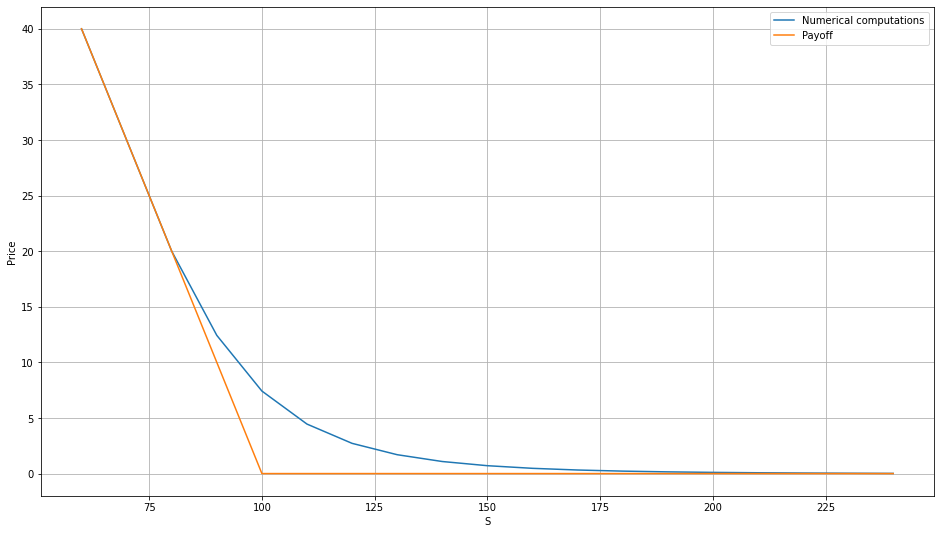

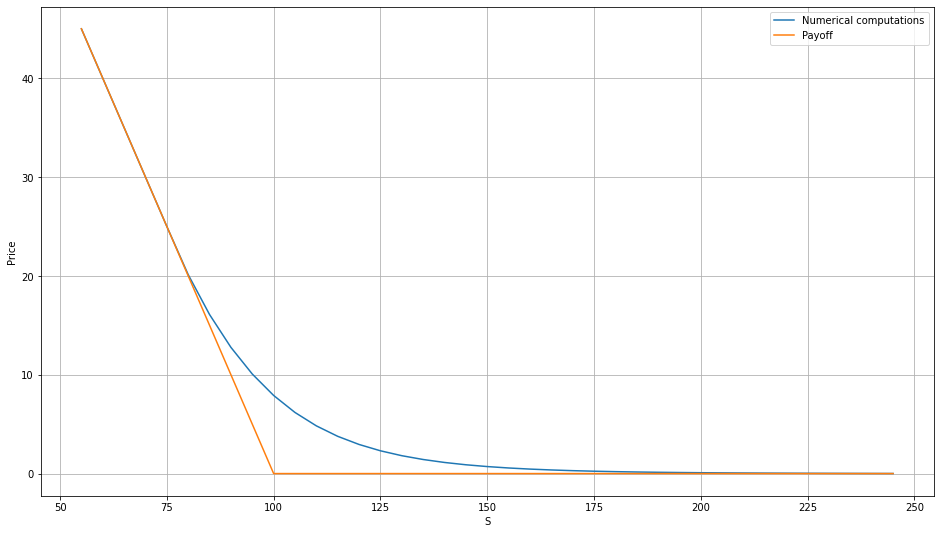

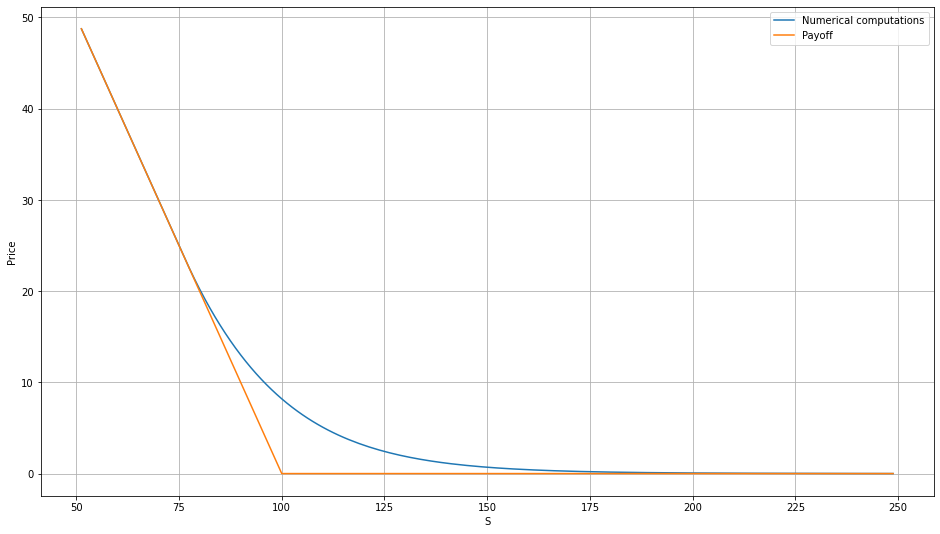

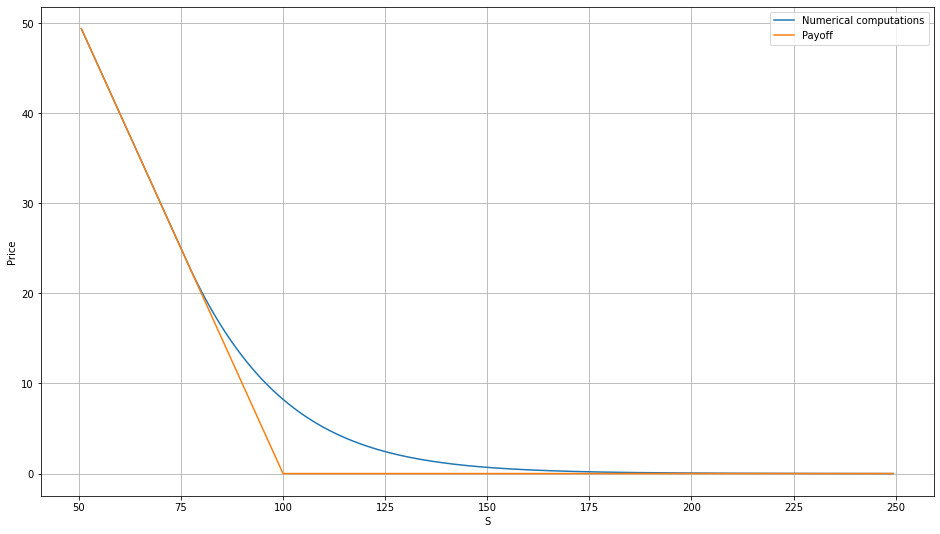

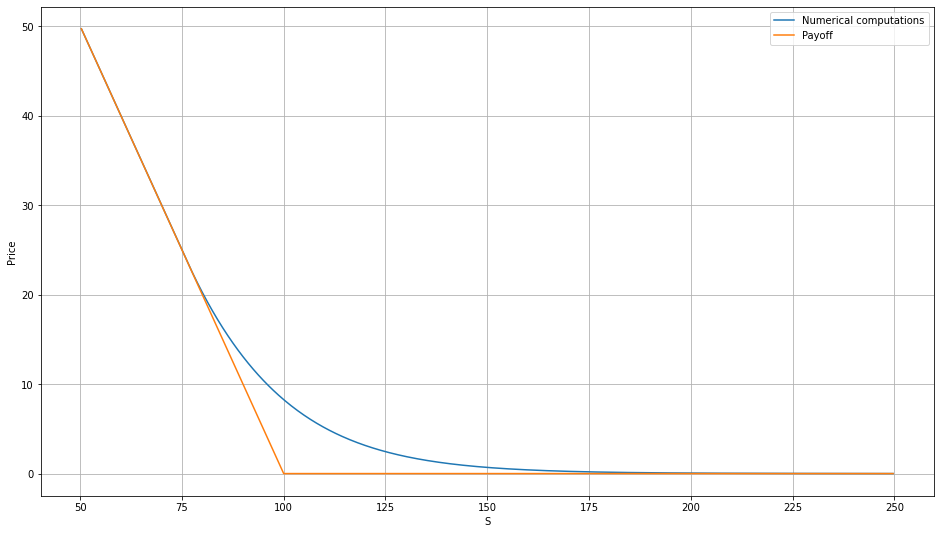

Wall time: 1min 48s


In [31]:
%%time
table_1=[]
#Possibilities are EE, IE-SPLIT, CN-SPLIT, IE-PSOR, IE-PSOR-RELAXED, IE-NEWTON, IE-UL, HIGHER_ORDER
#Scheme='IE-UL'
if Scheme=='EE':
    iteration_range=zip([19,39,79,159,319], [80,320,1280,5120,20480])
if (Scheme=='IE-SPLIT' or Scheme=='CN-SPLIT'):
    iteration_range=zip([19,39,159,319,639,1279], [20,40,160,320,640,1280])
if (Scheme=='IE-PSOR' or Scheme=='IE-PSOR-RELAXED'):
    iteration_range=zip([100,200],[10,20])
if (Scheme=='IE-NEWTON'):
    #iteration_range=zip([19,39,159,319], [20,40,160,320])
    iteration_range=zip([19,39,159,319,639], [2,4,16,32,64])
    #iteration_range=zip([1000], [10])
if (Scheme=='IE-UL'):
    #iteration_range=zip([19,39,159,319], [20,40,160,320])
    iteration_range=zip([1000], [10])
    #change below to get the graph for phi2 
    #S_min=0
if (Scheme=='HIGHER_ORDER'):
    #iteration_range=zip([19,39,159,319,639], [20,40,160,320,640])
    iteration_range=zip([19,39,159,319,639,1279], [2,4,16,32,64,128])
    
for I,N in iteration_range:
    start_time=time.time()
    h=(S_max-S_min)/(I+1)
    delta_t=T/N
    S=S_min*np.ones(I)+h*np.arange(1,I+1)
    alpha=(sigma**2/2)*(S**2/h**2)
    beta=r*S/(2*h)
    r_vec=np.ones(I)*r
    A=np.diag(2*alpha+r_vec)+np.diag(-alpha[1:]+beta[1:],-1)+np.diag(-alpha[0:-1]-beta[:-1],1)
    #in order to use phi2 initial condition one has to change phi to phi2 here and when making the graph
    #U=phi(S,I)
    U=phi(S,I)
    
    if (Scheme=='EE'):
        U=EE(N,U,A,delta_t,alpha,beta,S_min,I)
    if (Scheme=='IE-SPLIT'):
        U=IE_Split(N,U,A,delta_t,alpha,beta,S_min,I)
    if (Scheme=='CN-SPLIT'):
        U=CN_Split(N,U,A,delta_t,alpha,beta,S_min,I)
    if (Scheme=='IE-PSOR'):
        x0=np.ones_like(U)
        k_max=100
        U=IE_Psor(N,U,A,delta_t,alpha,beta,S_min,I,x0,k_max)
    if (Scheme=='IE-PSOR-RELAXED'):
        x0=np.ones_like(U)
        w=1.05
        k_max=100
        U=IE_Psor_relaxed(N,U,A,delta_t,alpha,beta,S_min,I,x0,k_max,w)
    if (Scheme=='IE-NEWTON'):
        x0=np.ones_like(U)
        k_max=5
        U=IE_Newton(N,U,A,delta_t,alpha,beta,S_min,I,x0,k_max)   
    if (Scheme=='IE-UL'):
        U=IE_UL(N,U,A,delta_t,alpha,beta,S_min,I)
    if (Scheme=='HIGHER_ORDER'):
        x0=np.ones_like(U)
        k_max=5
        eta=0.001
        xold=np.zeros_like(U)
        U=HIGHER_ORDER(N,U,A,delta_t,alpha,beta,S_min,I,x0,k_max,eta,xold)       
    
    plt.plot(S,U, label="Numerical computations")
    plt.xlabel("S")
    plt.ylabel("Price")
    plt.legend("Outcome of the computations")
    #in order to use phi2 initial condition one has to change phi to phi2 here
    plt.plot(S,phi(S,I),label="Payoff")
    #plt.plot(S,phi2(S,I),label="Payoff")
    plt.legend(loc="upper right")
    plt.grid()
    plt.show()
    
    table_1.append(
        {'I': I,
        'N': N,
        'computation time': time.time() - start_time,
        'U(%.2f)' %s_val:  interpolated_value(s_val,h,U,S,S_min)})
    
table_1=pd.DataFrame(table_1)

In [32]:
table_1=make_output_table (table_1,s_val,K,r,sigma)
table_1

,I,N,computation time,U(90.00),error,time error order,space error order
0,19,2,0.187254,12.428338,NaN,NaN,NaN
1,39,4,0.366745,12.769192,0.340854,NaN,NaN
2,159,16,2.100761,13.007505,0.238313,0.258147,0.258147
3,319,32,11.015571,13.042857,0.035352,2.753007,2.753007
4,639,64,94.695156,13.061459,0.018602,0.926307,0.926307
